# Workload Characterization

## Introduction

### Import relevant modules

In [62]:
# Data Analysis
import pandas as pd

# Data Visualization
from matplotlib import pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn import preprocessing

# Utilities
import numpy as np
# from tqdm import tnrange
import pickle
import os
from tqdm import tqdm_notebook as tqdmn
# import warnings

In [2]:
%config InlineBackend.figure_format = 'retina'

#### Low level parameters

In [3]:
df_low = pd.read_csv('WC_report_server.csv', sep='\s+', skiprows=1)
df_low.rename(columns={'r':'procs_r', 'b':'procs_b',
                       'swpd':'memory_swpd', 'free':'memory_free', 'buff':'memory_buff', 'cache':'memory_cache', 
                       'si':'swap_si', 'so':'swap_so', 
                       'bi':'io_bi', 'bo':'io_bo',
                       'in':'system_in', 'cs':'system_cs',
                       'us':'cpu_us', 'sy':'cpu_sy', 'id':'cpu_id', 'wa':'cpu_wa', 'st':'cpu_st'
                      }, inplace=True)
df_low.head()

procs_r  procs_b  memory_swpd  memory_free  memory_buff  memory_cache  \
0        3        0            0       753576        47736        611564   
1        0        0            0       753568        47740        611504   
2        0        0            0       753568        47740        611504   
3        0        0            0       753568        47740        611504   
4        0        0            0       753568        47740        611504   

   swap_si  swap_so  io_bi  io_bo  system_in  system_cs  cpu_us  cpu_sy  \
0        0        0    689     41        470        435       5       4   
1        0        0      4     36        402       1212      11       1   
2        0        0      0      0         82        180       3       0   
3        0        0      0      0         54         90       1       0   
4        0        0      0      0         69        157       0       0   

   cpu_id  cpu_wa  cpu_st  
0      87       4       0  
1      87       1       0  
2      97       0       0  
3      99       0       0  
4     100       0       0

In [4]:
print('The dataset contains', df_low.shape[1], 'columns and', df_low.shape[0], 'rows')

The dataset contains 17 columns and 310 rows


# High level parameters

## Read data

In [5]:
df_high = pd.read_csv('WC_report_client.csv')
df_high.head()

timeStamp  elapsed                           label  responseCode  \
0  1609346383111       48   HTTP Request - Wikipedia Home           200   
1  1609346383111       48      HTTP Request - Reddit Home           200   
2  1609346383111       48  HTTP Request - Repubblica Home           200   
3  1609346383422        2   HTTP Request - Wikipedia Home           200   
4  1609346383469        9      HTTP Request - Reddit Home           200   

  responseMessage               threadName dataType  success  failureMessage  \
0              OK  Thread Group - Slow 1-1     text     True             NaN   
1              OK  Thread Group - Fast 2-1     text     True             NaN   
2              OK  Thread Group - Home 3-1     text     True             NaN   
3              OK  Thread Group - Fast 2-2     text     True             NaN   
4              OK  Thread Group - Slow 1-2     text     True             NaN   

    bytes  sentBytes  grpThreads  allThreads  \
0   78492        134           1           3   
1  911062        131           1           3   
2  387753        135           1           3   
3   78492        134           2           6   
4  911062        131           2           6   

                                         URL  Latency  IdleTime  Connect  
0   http://192.168.56.101/WikipediaHome.html       45         0       30  
1      http://192.168.56.101/RedditHome.html       45         0       30  
2  http://192.168.56.101/RepubblicaHome.html       45         0       30  
3   http://192.168.56.101/WikipediaHome.html        2         0        1  
4      http://192.168.56.101/RedditHome.html        2         0        1

In [6]:
print('The dataset contains', df_high.shape[1], 'columns and', df_high.shape[0], 'rows')

The dataset contains 17 columns and 6338 rows


In [7]:
df_high['success'].all()

True

In [8]:
df_high.loc[df_high['label'].str.contains('Wikipedia'), 'resourceType'] = 'small'
df_high.loc[df_high['label'].str.contains('Repubblica'), 'resourceType'] = 'medium'
df_high.loc[df_high['label'].str.contains('Reddit'), 'resourceType'] = 'large'

df_high.loc[df_high['threadName'].str.contains('Slow'), 'threadType'] = 'slow'
df_high.loc[df_high['threadName'].str.contains('Fast'), 'threadType'] = 'fast'
df_high.loc[df_high['threadName'].str.contains('Home'), 'threadType'] = 'home'

df_high.head()

timeStamp  elapsed                           label  responseCode  \
0  1609346383111       48   HTTP Request - Wikipedia Home           200   
1  1609346383111       48      HTTP Request - Reddit Home           200   
2  1609346383111       48  HTTP Request - Repubblica Home           200   
3  1609346383422        2   HTTP Request - Wikipedia Home           200   
4  1609346383469        9      HTTP Request - Reddit Home           200   

  responseMessage               threadName dataType  success  failureMessage  \
0              OK  Thread Group - Slow 1-1     text     True             NaN   
1              OK  Thread Group - Fast 2-1     text     True             NaN   
2              OK  Thread Group - Home 3-1     text     True             NaN   
3              OK  Thread Group - Fast 2-2     text     True             NaN   
4              OK  Thread Group - Slow 1-2     text     True             NaN   

    bytes  sentBytes  grpThreads  allThreads  \
0   78492        134           1           3   
1  911062        131           1           3   
2  387753        135           1           3   
3   78492        134           2           6   
4  911062        131           2           6   

                                         URL  Latency  IdleTime  Connect  \
0   http://192.168.56.101/WikipediaHome.html       45         0       30   
1      http://192.168.56.101/RedditHome.html       45         0       30   
2  http://192.168.56.101/RepubblicaHome.html       45         0       30   
3   http://192.168.56.101/WikipediaHome.html        2         0        1   
4      http://192.168.56.101/RedditHome.html        2         0        1   

  resourceType threadType  
0        small       slow  
1        large       fast  
2       medium       home  
3        small       fast  
4        large       slow

## Data analysis

In [9]:
df_high.describe()

timeStamp      elapsed  responseCode  failureMessage          bytes  \
count  6.338000e+03  6338.000000        6338.0             0.0    6338.000000   
mean   1.609347e+12     8.330388         200.0             NaN  453655.431209   
std    8.455378e+04     8.139487           0.0             NaN  334132.008234   
min    1.609346e+12     0.000000         200.0             NaN   78491.000000   
25%    1.609346e+12     3.000000         200.0             NaN   93219.000000   
50%    1.609347e+12     6.000000         200.0             NaN  387752.000000   
75%    1.609347e+12    10.000000         200.0             NaN  857514.000000   
max    1.609347e+12    84.000000         200.0             NaN  911062.000000   

         sentBytes   grpThreads   allThreads      Latency  IdleTime  \
count  6338.000000  6338.000000  6338.000000  6338.000000    6338.0   
mean    133.297570    37.579363    97.528085     2.586936       0.0   
std       1.707357     6.852841    11.239369     3.967968       0.0   
min     131.000000     1.000000     1.000000     0.000000       0.0   
25%     131.000000    40.000000   100.000000     1.000000       0.0   
50%     134.000000    40.000000   100.000000     1.000000       0.0   
75%     135.000000    40.000000   100.000000     3.000000       0.0   
max     135.000000    40.000000   100.000000    73.000000       0.0   

           Connect  
count  6338.000000  
mean      0.502209  
std       1.427014  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       1.000000  
max      30.000000

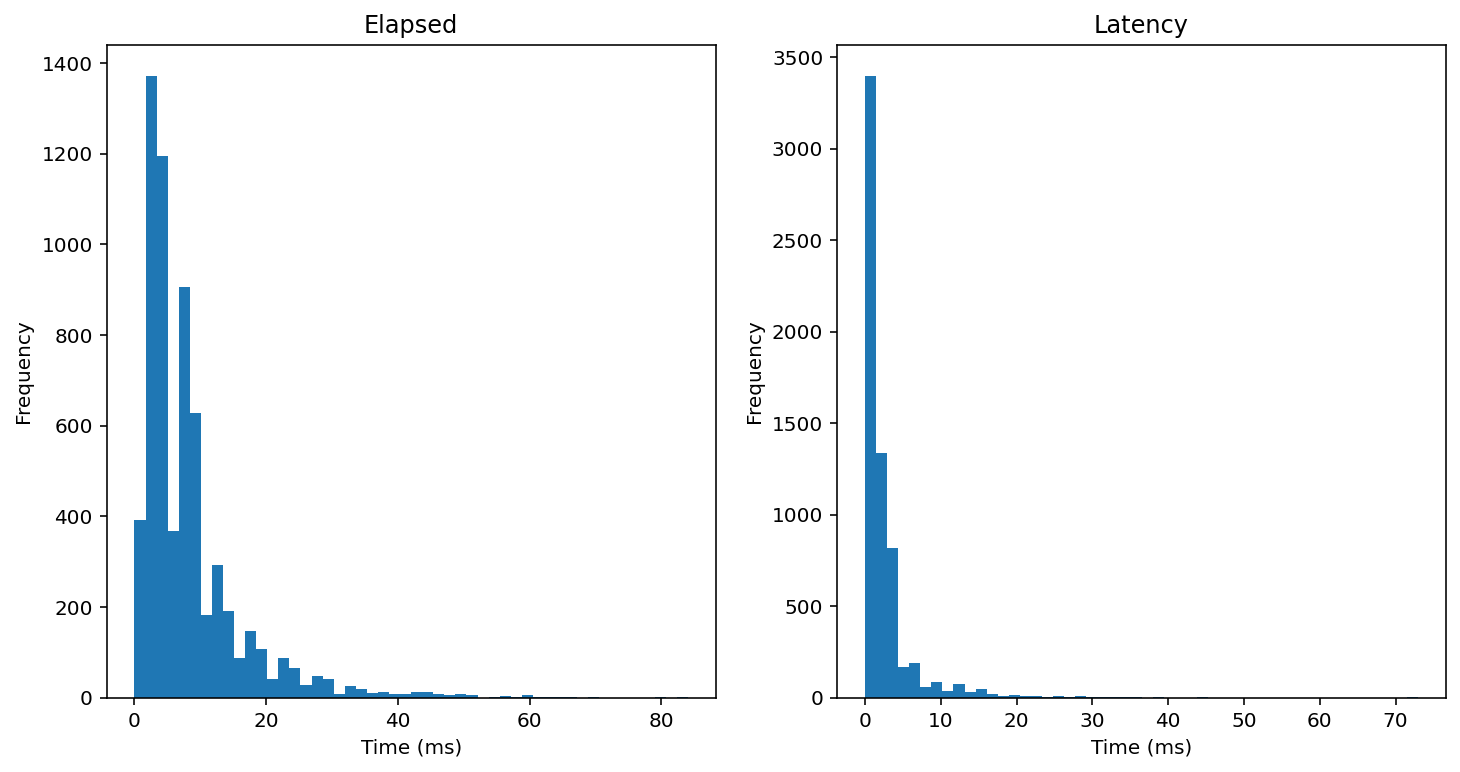

In [10]:
fig = plt.figure(figsize=(12,6))

ax0 = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2)

df_high.elapsed.plot.hist(bins=50, ax=ax0)
df_high.Latency.plot.hist(bins=50, ax=ax1)

ax0.set_title('Elapsed')
ax0.set_xlabel('Time (ms)')
# ax0.set_xticks(np.arange(0, max(df_high.elapsed), 5))

ax1.set_title('Latency')
ax1.set_xlabel('Time (ms)')
# ax1.set_xticks(np.arange(0, max(df_high.Latency), 5))

plt.show()

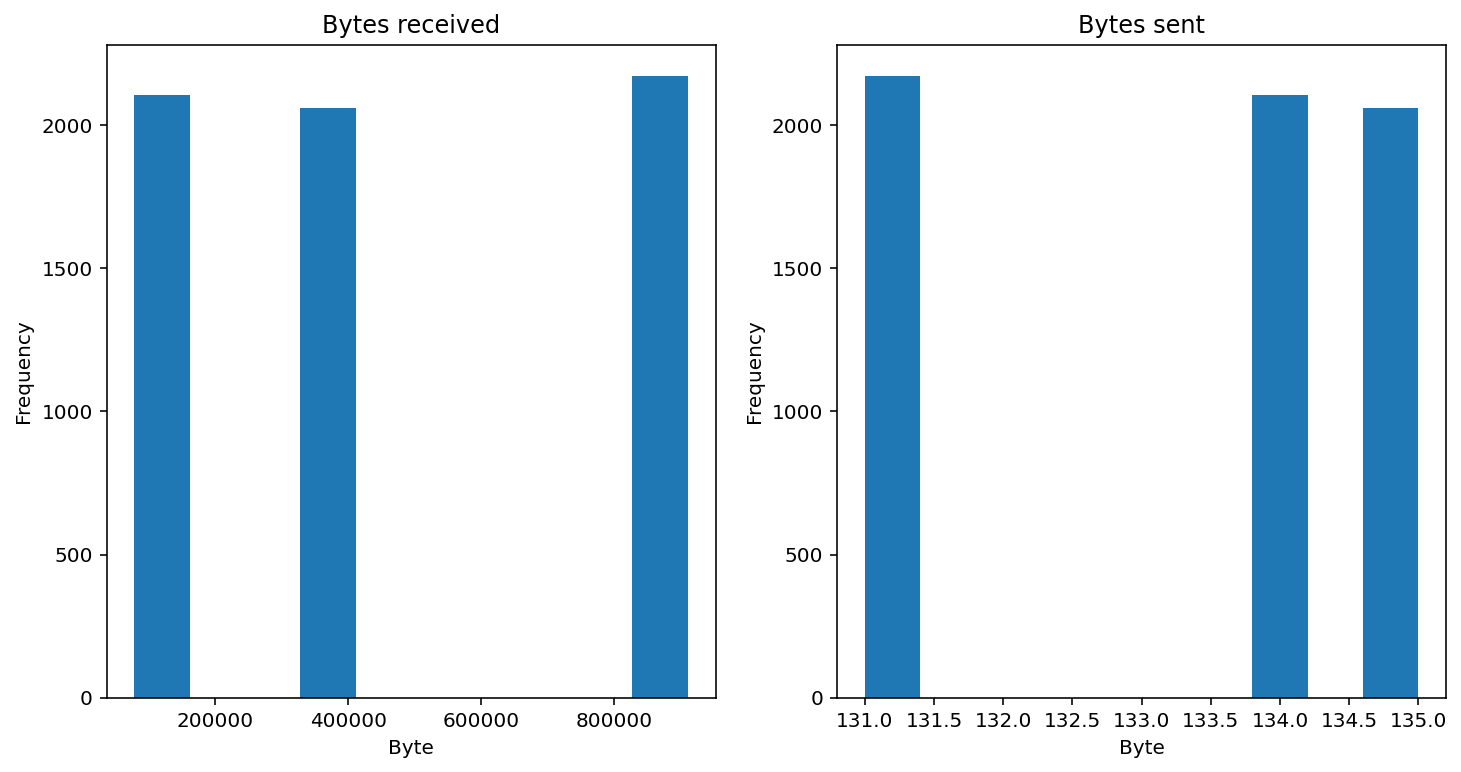

In [12]:
fig = plt.figure(figsize=(12,6))

ax0 = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2)

df_high.bytes.plot.hist(ax=ax0)
df_high.sentBytes.plot.hist(ax=ax1)

ax0.set_title('Bytes received')
ax0.set_xlabel('Byte')

ax1.set_title('Bytes sent')
ax1.set_xlabel('Byte')

plt.show()

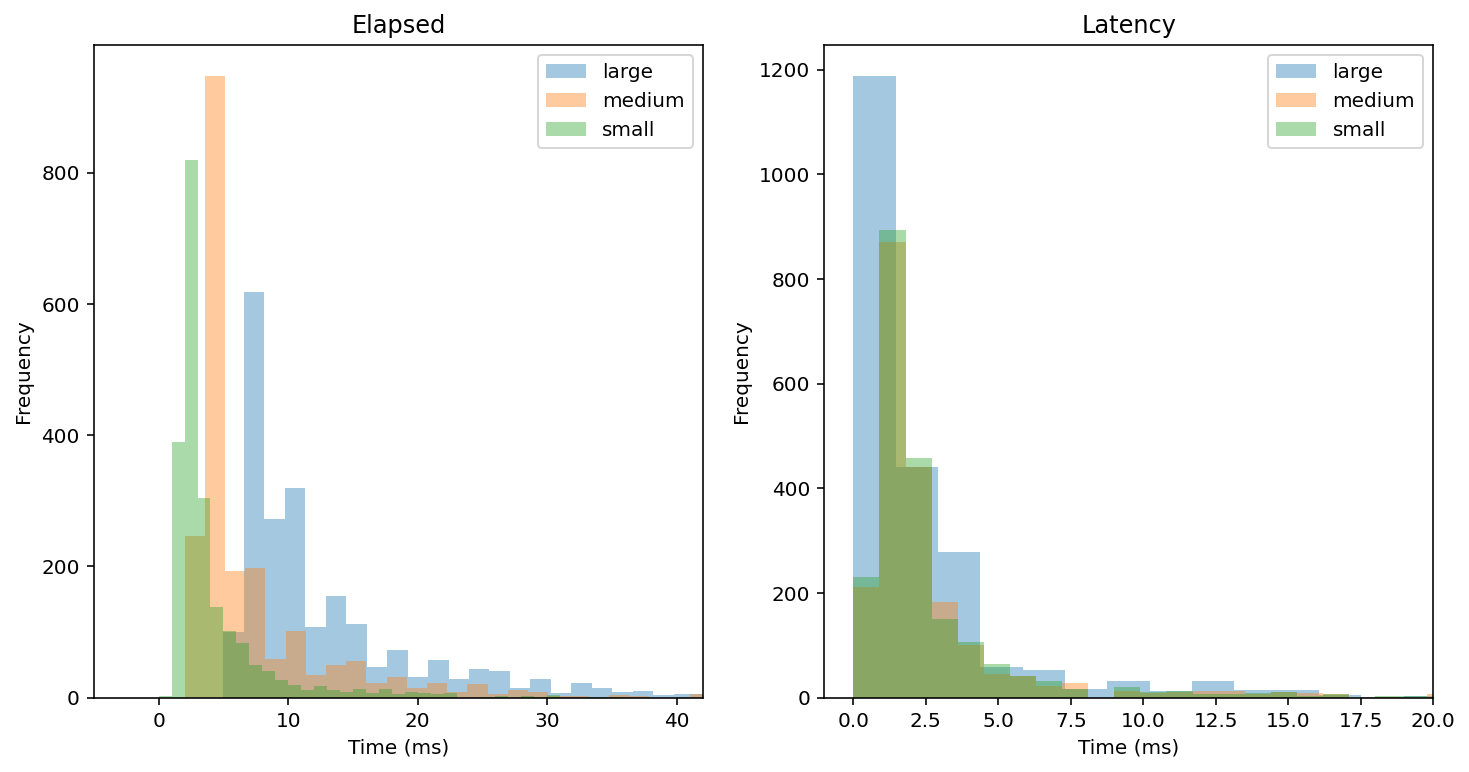

In [28]:
fig = plt.figure(figsize=(12,6))

ax0 = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2)

df_high.groupby(by='resourceType').elapsed.plot.hist(bins=50, alpha=0.4, legend=True, ax=ax0)
df_high.groupby(by='resourceType').Latency.plot.hist(bins=50, alpha=0.4, legend=True, ax=ax1)

x_max = df_high.quantile(q=0.99).elapsed
ax0.set_xlim(-5,x_max)
ax0.set_title('Elapsed')
ax0.set_xlabel('Time (ms)')
# ax0.set_xticks(np.arange(0, max(df_high.elapsed)+1, 5))

x_max = df_high.quantile(q=0.99).Latency
ax1.set_xlim(-1,x_max)
ax1.set_title('Latency')
ax1.set_xlabel('Time (ms)')
# ax1.set_xticks(np.arange(0, max(df_high.Latency)+1, 5))

plt.show()

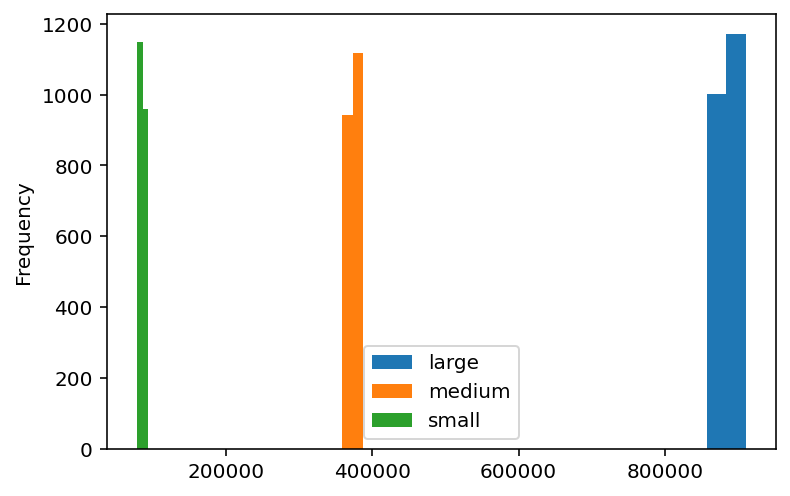

In [14]:
df_high.groupby(by='resourceType').bytes.plot.hist(bins=2, alpha=1, legend=True)

plt.show()

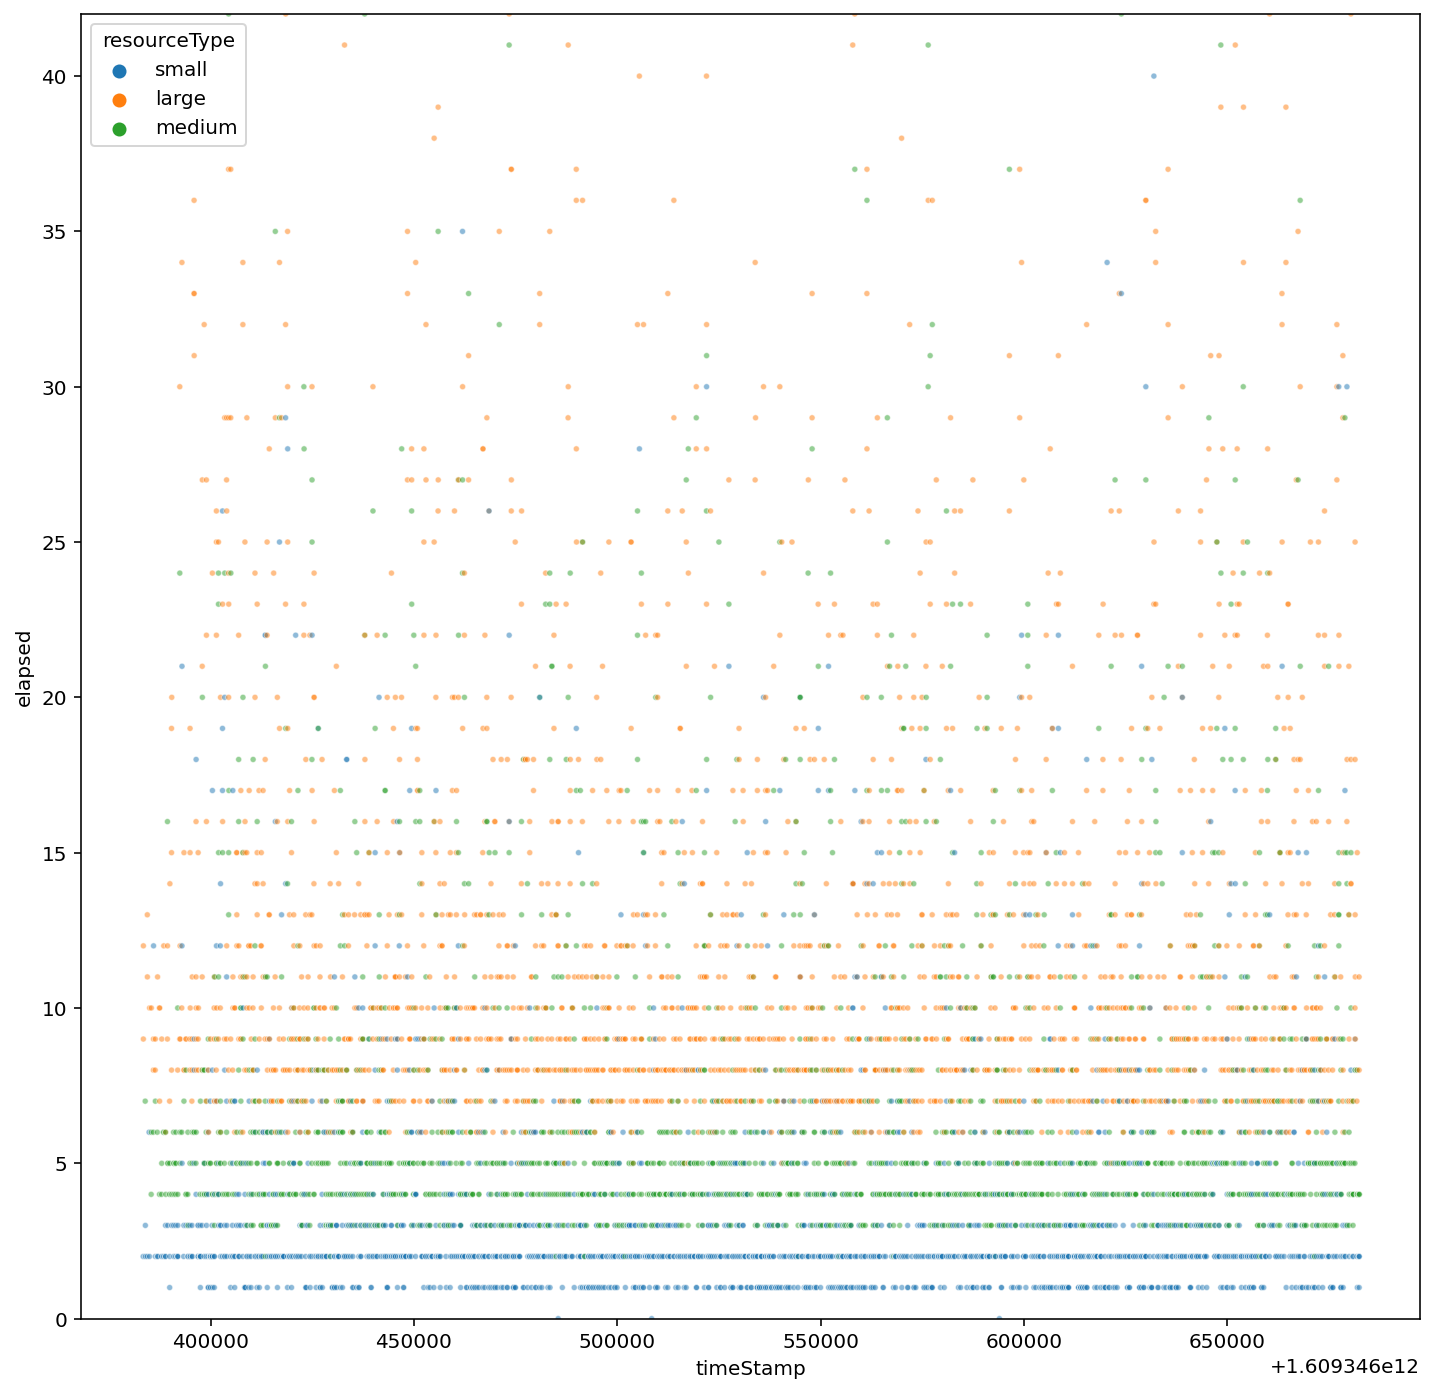

In [15]:
fig, ax = plt.subplots(figsize=(12,12))
sns.scatterplot(x='timeStamp', y='elapsed', hue='resourceType', data=df_high, marker='.', alpha=.5)
y_max = df_high.quantile(q=0.99).elapsed
plt.ylim(0,y_max)
plt.show()

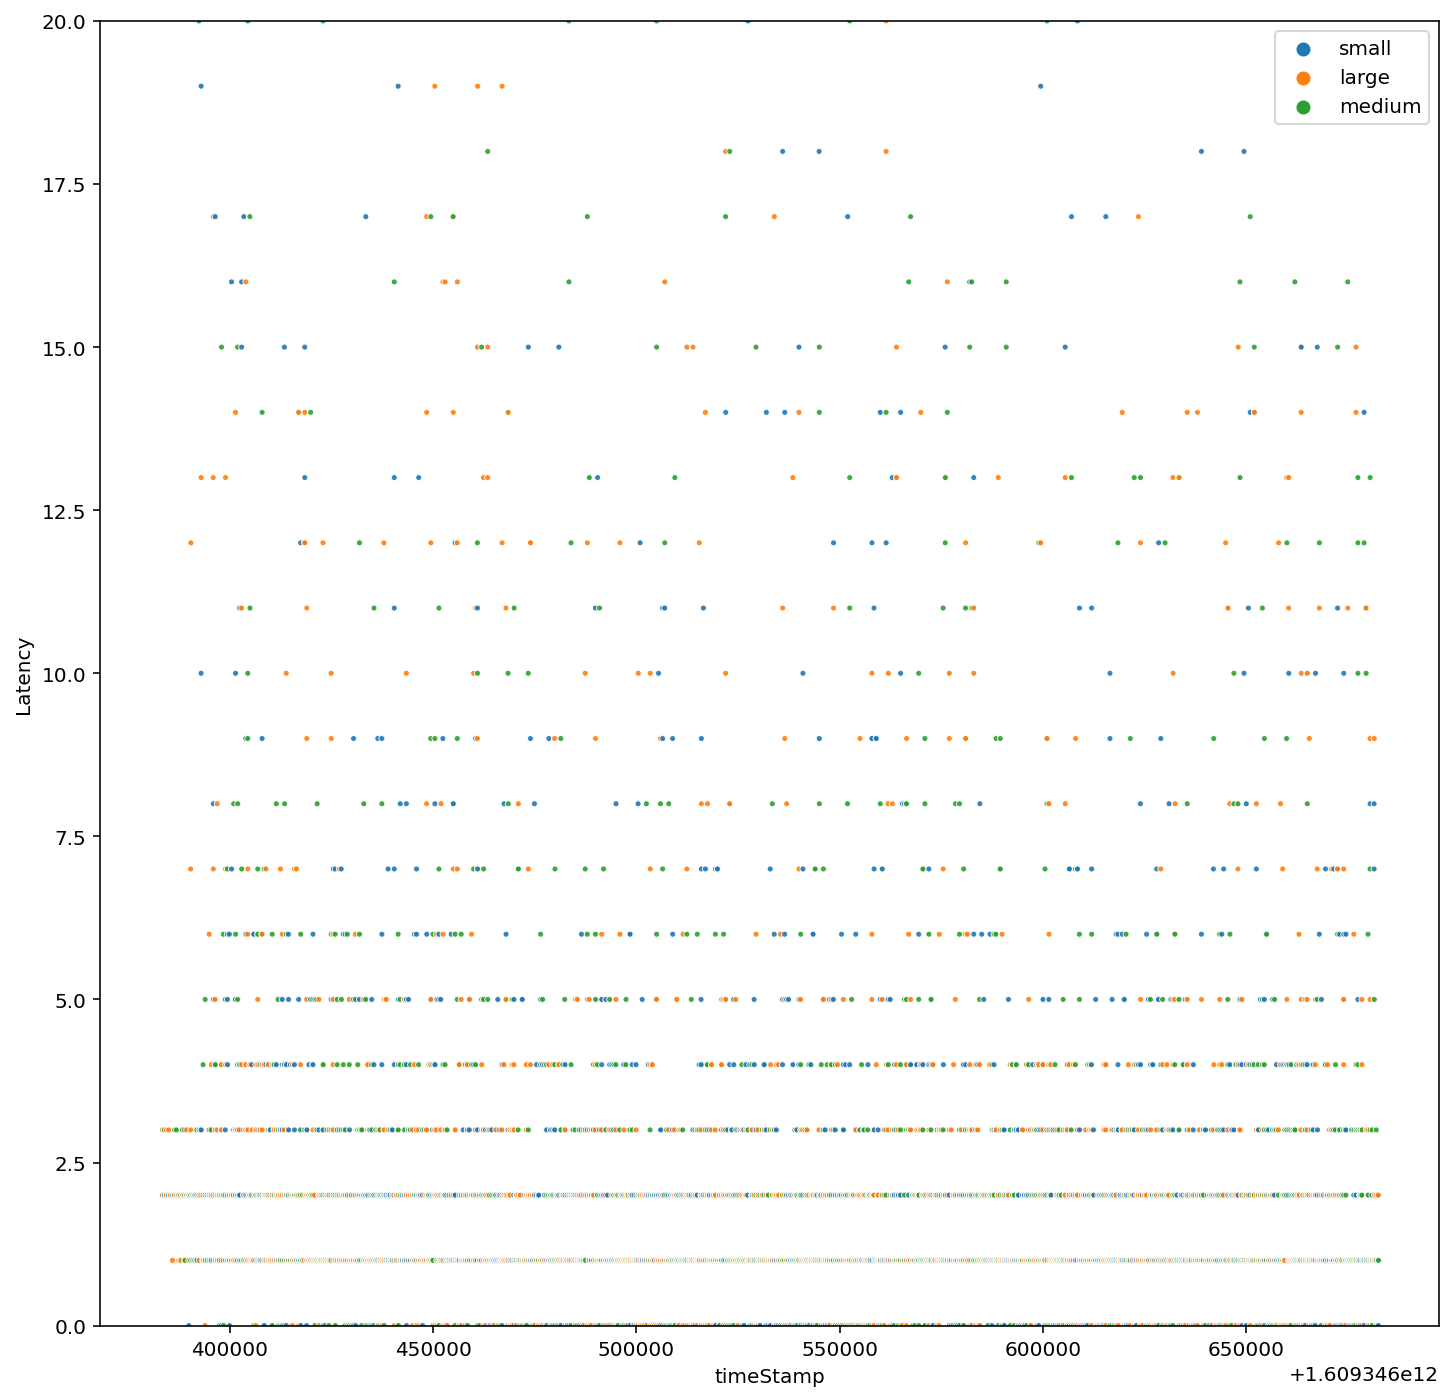

In [16]:
fig, ax = plt.subplots(figsize=(12,12))
sns.scatterplot(x='timeStamp', y='Latency', hue='resourceType', data=df_high, marker='.', alpha=.9)
y_max = df_high.quantile(q=0.99).Latency
plt.legend(loc='upper right')
plt.ylim(0,y_max)
plt.show()

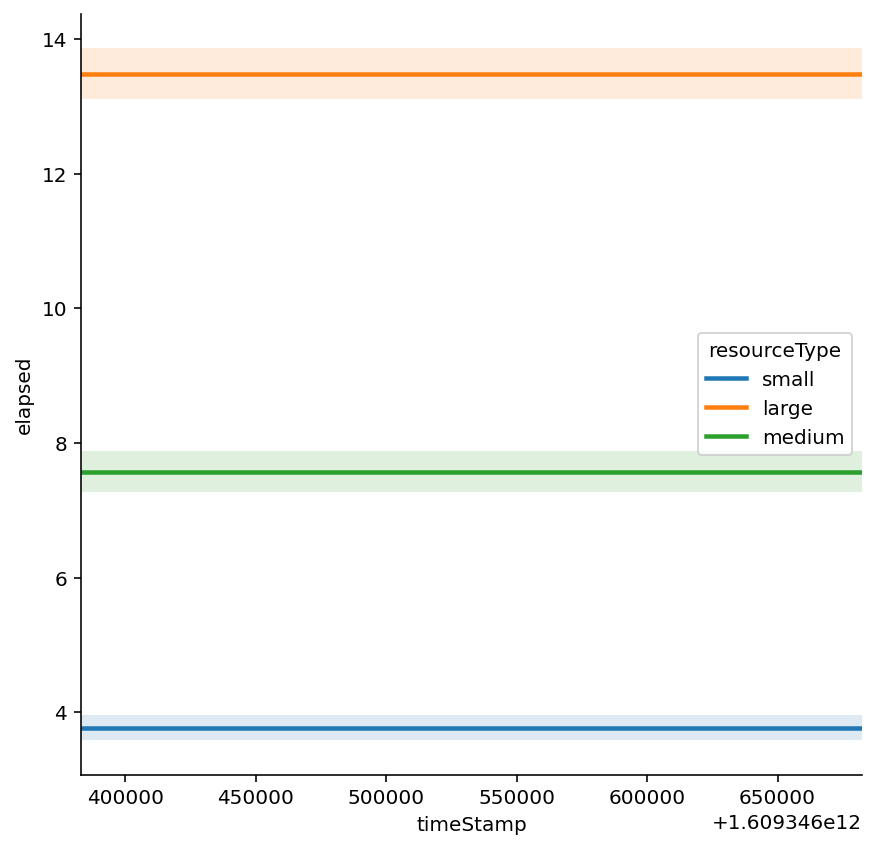

In [17]:
sns.lmplot(x='timeStamp', y='elapsed', hue='resourceType', data=df_high, markers='.', legend_out=False, scatter=False, height=6)
plt.show()

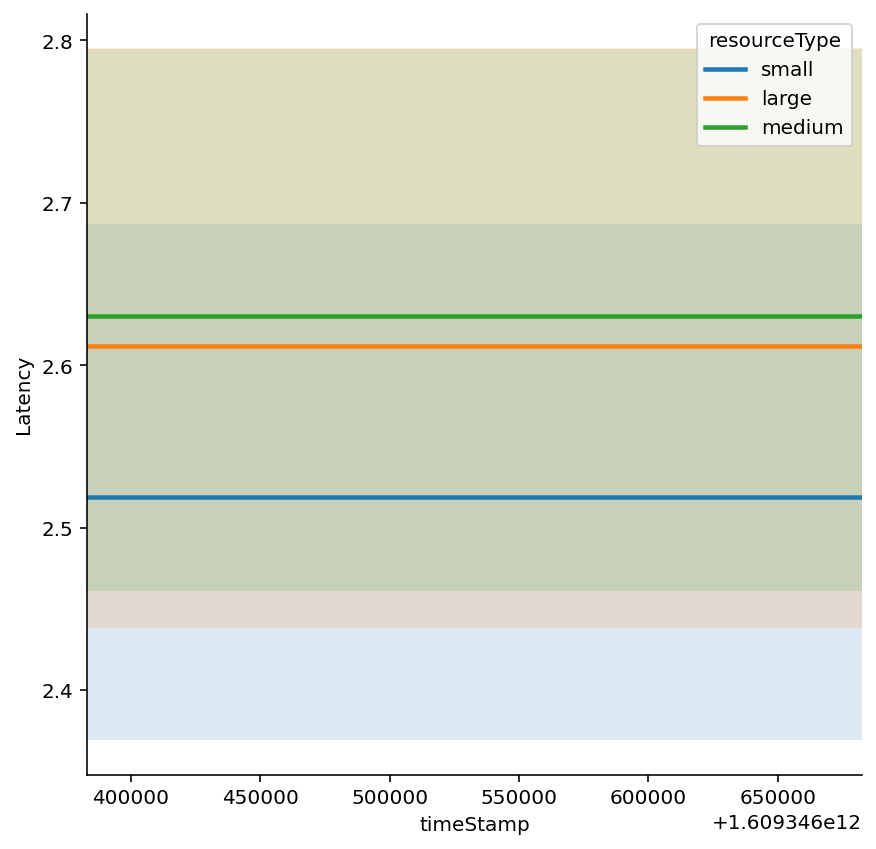

In [18]:
sns.lmplot(x='timeStamp', y='Latency', hue='resourceType', data=df_high, markers='.', legend_out=False, scatter=False, height=6)
plt.show()

## PCA

### Preprocessing

#### Remove nominal columns

In [29]:
df_high_pre = df_high.select_dtypes(include=['int64']).copy().drop(columns='responseCode')
df_high_pre.head()

timeStamp  elapsed   bytes  sentBytes  grpThreads  allThreads  Latency  \
0  1609346383111       48   78492        134           1           3       45   
1  1609346383111       48  911062        131           1           3       45   
2  1609346383111       48  387753        135           1           3       45   
3  1609346383422        2   78492        134           2           6        2   
4  1609346383469        9  911062        131           2           6        2   

   IdleTime  Connect  
0         0       30  
1         0       30  
2         0       30  
3         0        1  
4         0        1

In [30]:
thread_type_encoder = preprocessing.LabelEncoder()
thread_type_encoder.fit(['slow','fast','home'])

df_high_pre['threadType'] = thread_type_encoder.transform(df_high['threadType'])
df_high_pre

timeStamp  elapsed   bytes  sentBytes  grpThreads  allThreads  \
0     1609346383111       48   78492        134           1           3   
1     1609346383111       48  911062        131           1           3   
2     1609346383111       48  387753        135           1           3   
3     1609346383422        2   78492        134           2           6   
4     1609346383469        9  911062        131           2           6   
...             ...      ...     ...        ...         ...         ...   
6333  1609346682424       11  911061        131           4           5   
6334  1609346682433        8  911061        131           3           4   
6335  1609346682442        1   78491        134           2           3   
6336  1609346682458        2   93220        134           1           2   
6337  1609346682483        4  358467        135           1           1   

      Latency  IdleTime  Connect  threadType  
0          45         0       30           2  
1          45         0       30           0  
2          45         0       30           1  
3           2         0        1           0  
4           2         0        1           2  
...       ...       ...      ...         ...  
6333        1         0        0           0  
6334        2         0        0           0  
6335        0         0        0           0  
6336        1         0        0           2  
6337        1         0        0           0  

[6338 rows x 10 columns]

#### Remove constant components

In [31]:
df_const = df_high_pre.loc[:,df_high_pre.columns[df_high_pre.nunique() == 1]]
df_const.head()

IdleTime
0         0
1         0
2         0
3         0
4         0

In [32]:
df_high_pre = df_high_pre.loc[:,df_high_pre.columns[df_high_pre.nunique() != 1]]
df_high_pre.head()

timeStamp  elapsed   bytes  sentBytes  grpThreads  allThreads  Latency  \
0  1609346383111       48   78492        134           1           3       45   
1  1609346383111       48  911062        131           1           3       45   
2  1609346383111       48  387753        135           1           3       45   
3  1609346383422        2   78492        134           2           6        2   
4  1609346383469        9  911062        131           2           6        2   

   Connect  threadType  
0       30           2  
1       30           0  
2       30           1  
3        1           0  
4        1           2

#### Remove perfectly correlated components

In [33]:
df_corr = df_high_pre.corr()
df_corr

timeStamp   elapsed     bytes  sentBytes  grpThreads  allThreads  \
timeStamp    1.000000 -0.011575  0.002689   0.010882    0.085292    0.057491   
elapsed     -0.011575  1.000000  0.495622  -0.398989   -0.019038   -0.009292   
bytes        0.002689  0.495622  1.000000  -0.824786    0.006180   -0.007324   
sentBytes    0.010882 -0.398989 -0.824786   1.000000   -0.012107   -0.004037   
grpThreads   0.085292 -0.019038  0.006180  -0.012107    1.000000    0.603641   
allThreads   0.057491 -0.009292 -0.007324  -0.004037    0.603641    1.000000   
Latency     -0.036725  0.628795  0.008536  -0.001676   -0.055446   -0.046135   
Connect     -0.050421  0.291343  0.005382  -0.000335   -0.194612   -0.099155   
threadType  -0.006055  0.036047 -0.016702   0.010106   -0.097309   -0.010379   

             Latency   Connect  threadType  
timeStamp  -0.036725 -0.050421   -0.006055  
elapsed     0.628795  0.291343    0.036047  
bytes       0.008536  0.005382   -0.016702  
sentBytes  -0.001676 -0.000335    0.010106  
grpThreads -0.055446 -0.194612   -0.097309  
allThreads -0.046135 -0.099155   -0.010379  
Latency     1.000000  0.432882    0.051224  
Connect     0.432882  1.000000    0.354500  
threadType  0.051224  0.354500    1.000000

#### Normalize the components

In [34]:
x = df_high_pre.values

x_scaled = StandardScaler().fit_transform(x)

df_high_pre = pd.DataFrame(data=x_scaled, columns=df_high_pre.columns )
df_high_pre.head()

timeStamp   elapsed     bytes  sentBytes  grpThreads  allThreads  \
0  -1.810683  4.874108 -1.122889   0.411446   -5.338260   -8.411108   
1  -1.810683  4.874108  1.369048  -1.345795   -5.338260   -8.411108   
2  -1.810683  4.874108 -0.197250   0.997193   -5.338260   -8.411108   
3  -1.807004 -0.777799 -1.122889   0.411446   -5.192324   -8.144168   
4  -1.806449  0.082274  1.369048  -1.345795   -5.192324   -8.144168   

     Latency    Connect  threadType  
0  10.689706  20.672621    1.434312  
1  10.689706  20.672621   -0.763625  
2  10.689706  20.672621    0.335343  
3  -0.147930   0.348862   -0.763625  
4  -0.147930   0.348862    1.434312

### Perform PCA

In [36]:
pca = PCA()

princ_comp = pca.fit(df_high_pre.values)

In [37]:
d = pca.transform(df_high_pre.values)

c = [str(s) for s in range(princ_comp.n_components_)]
c = ['comp ' + s for s in c]

df_high_pca = pd.DataFrame(data=d, columns=c)
df_high_pca.head()

comp 0     comp 1    comp 2    comp 3    comp 4     comp 5    comp 6  \
0  13.415712  18.890147  4.146692  1.172873  0.343035   9.794115  4.435021   
1  15.200704  16.739363  2.687261  2.250220  0.409215  11.274867  4.463244   
2  13.481792  18.474017  3.886944  2.017720  0.443000  10.320455  4.396080   
3   0.171065   6.412197 -7.083113  1.973358 -0.073933  -0.339520  1.926723   
4   2.887850   5.439673 -7.656743 -0.231086 -0.310282  -1.309808  1.993626   

     comp 7    comp 8  
0  0.537570  0.057810  
1  0.898402 -0.777582  
2  0.023957 -0.889043  
3  0.143297  0.501105  
4  0.202296 -0.088533

#### Explained variance

In [38]:
d = {'explained variance': princ_comp.explained_variance_, 'explained variance ratio': princ_comp.explained_variance_ratio_}

df_variance_PCA = pd.DataFrame(data=d)

df_variance_PCA['cumulative explained variance ratio'] = df_variance_PCA.cumsum()['explained variance ratio']
df_variance_PCA.head(10)

explained variance  explained variance ratio  \
0            2.350027                  0.261073   
1            1.837283                  0.204110   
2            1.474467                  0.163804   
3            1.058424                  0.117584   
4            0.982782                  0.109181   
5            0.510879                  0.056755   
6            0.385547                  0.042832   
7            0.254838                  0.028311   
8            0.147173                  0.016350   

   cumulative explained variance ratio  
0                             0.261073  
1                             0.465183  
2                             0.628987  
3                             0.746571  
4                             0.855752  
5                             0.912507  
6                             0.955339  
7                             0.983650  
8                             1.000000

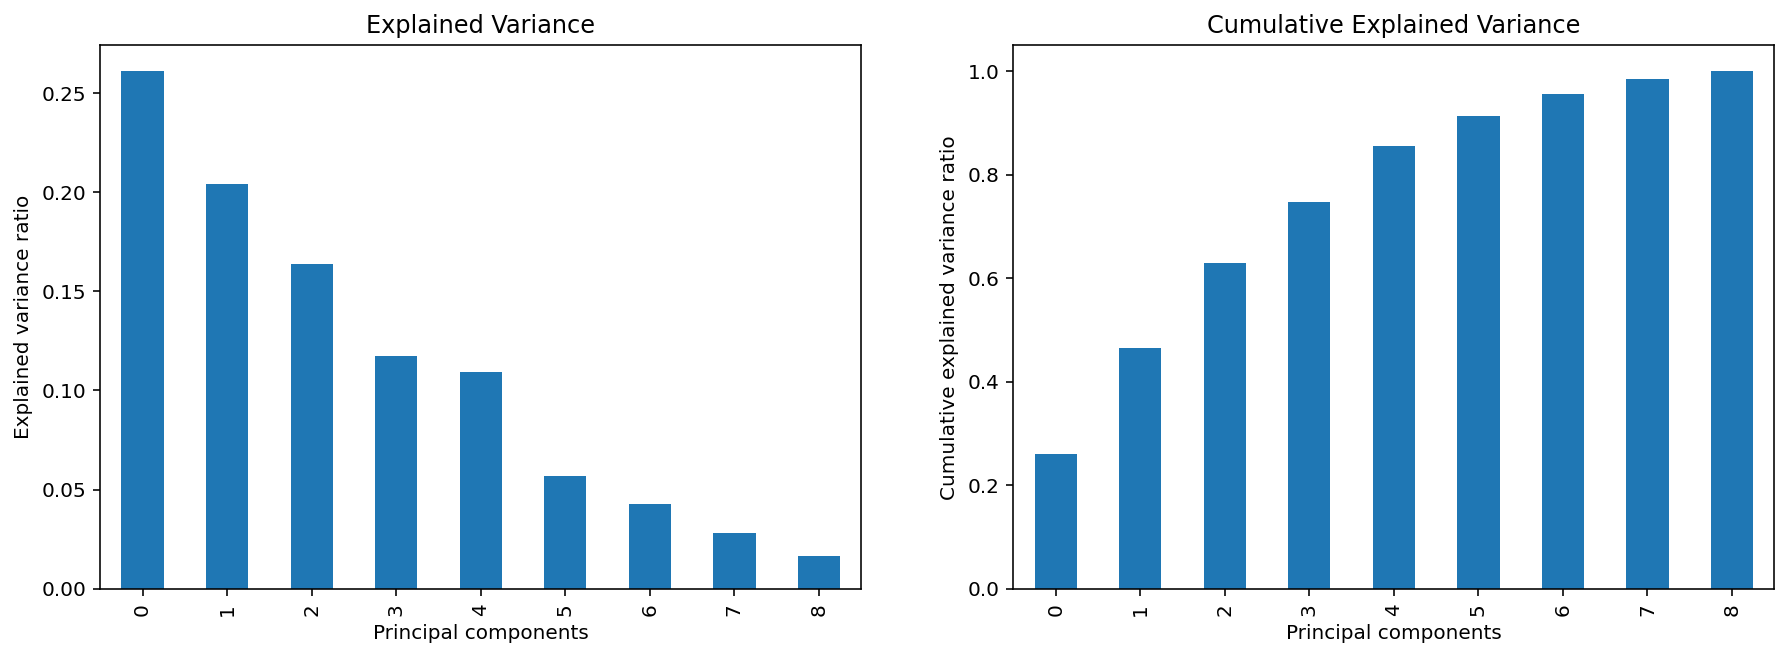

In [39]:
fig = plt.figure(figsize=(15,5))

ax0 = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(1, 2, 2)

df_variance_PCA.plot.bar(y=['explained variance ratio'], ax=ax0, legend=False)
df_variance_PCA.plot.bar(y=['cumulative explained variance ratio'], ax=ax1, legend=False)

ax0.set_title('Explained Variance')
ax0.set_xlabel('Principal components')
ax0.set_ylabel('Explained variance ratio')

ax1.set_title('Cumulative Explained Variance')
ax1.set_xlabel('Principal components')
ax1.set_ylabel('Cumulative explained variance ratio')
plt.show()

## Clustering

### Select principal components

In [ ]:

dev_tot = df_high_pre.sub(df_high_pre.mean()).pow(2).sum().sum()

nmin_comp = 4
nmax_comp = 9
n_comp = nmax_comp-nmin_comp+1

nmax_cluster = 50

array_dev_lost = np.zeros(shape=(nmax_cluster,n_comp))
filepath = './array_dev_lost.txt'
if(not os.path.isfile(filepath)):
    print('Creating file',filepath, 'this may take a while...\n')
    
    array_dev_lost = np.zeros(shape=(nmax_cluster,n_comp))
    
    for i in tqdmn(range(nmin_comp, nmax_comp+1), desc='outer loop'):

        for j in tqdmn(range(1, nmax_cluster+1), desc='inner loop'):
            df_clustering = df_high_pca.iloc[:,0:i]

            # clustering
            clustering = AgglomerativeClustering(n_clusters=j)
            clustering = clustering.fit(df_clustering.values)

            df_clustering.insert(len(df_clustering.columns), 'cluster', clustering.labels_)

            # deviance PCA
            df_pca = df_high_pca.iloc[:,0:i]
            dev_pca = df_pca.sub(df_pca.mean()).pow(2).sum().sum()

            # deviance clustering 
            n_elem = df_clustering.groupby('cluster').count().values[:,0]
            centroids = df_clustering.groupby('cluster').mean()

            # intra-cluster deviance
            arr = np.zeros(shape=(j,1))
            for k in range(j):
                elem_k = df_clustering.loc[df_clustering['cluster'] == k].drop(columns='cluster')
                arr[k] = elem_k.sub(centroids.loc[k,:]).pow(2).sum().sum()
            dev_intra = arr.sum()

            # inter-cluster deviance
            dev_inter = centroids.sub(df_clustering.mean()).pow(2).mul(n_elem, axis=0).sum().sum()
            dev_inter

            # deviance lost
            dev_pca_ratio = dev_pca/dev_tot
            dev_inter_ratio = dev_inter/dev_pca
            dev_lost = 1 - dev_inter_ratio * dev_pca_ratio

            array_dev_lost[j-1][i-n_comp] = dev_lost
            
    with open (filepath, 'wb') as fp:
        pickle.dump(array_dev_lost, fp)

else:
    print('File already exists!\n')
    with open (filepath, 'rb') as fp:
        array_dev_lost = pickle.load(fp)
        
        
# array_dev_lost

Creating file ./array_dev_lost.txt this may take a while...



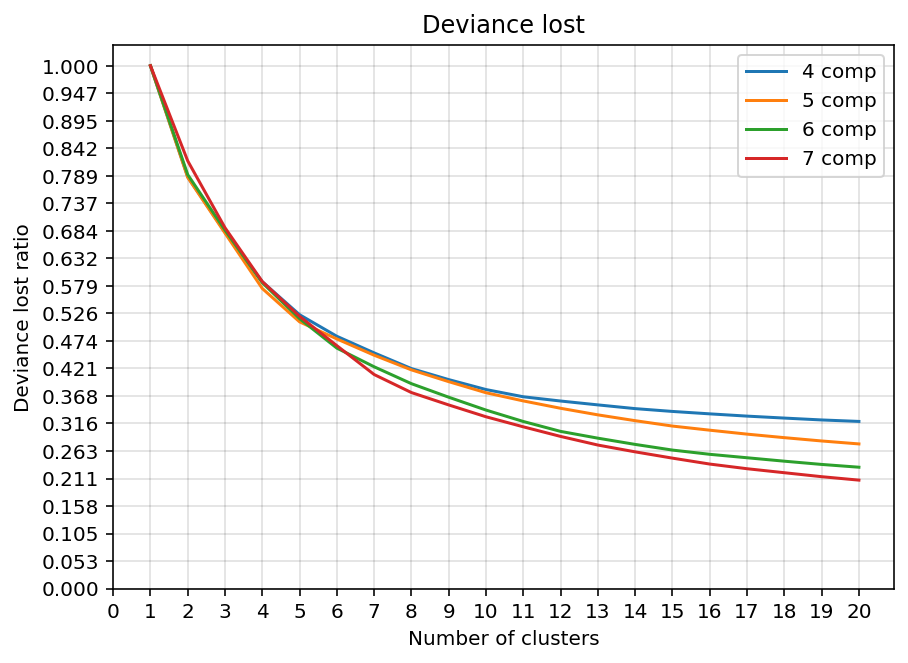

In [71]:
x = np.arange(1,nmax_cluster+1)

plt.figure(figsize=(7,5))

for i in range(nmin_comp,nmax_comp+1):
    y_dev_lost = array_dev_lost[:,i-n_comp]
    plt.plot(x, y_dev_lost)
    
c = [str(s) for s in range(nmin_comp,nmax_comp+1)]
c = [s + ' comp' for s in c]
    
plt.title('Deviance lost')
plt.ylabel('Deviance lost ratio')
plt.xlabel('Number of clusters')
plt.xticks(range(nmax_cluster+1))
plt.yticks(np.linspace(0,y_dev_lost.max(),20))
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.legend(c)
plt.show()


In [30]:
n_comp = 2
df_high_cl = df_high_pca.iloc[:,0:n_comp]
df_high_cl.head()

comp 0     comp 1
0  12.126109  28.368298
1  12.199340  28.589295
2  15.738922  28.036423
3   2.981407  11.484857
4   0.671840  11.838639

### Perform clustering

In [31]:
n_clusters = 3

clustering = AgglomerativeClustering(n_clusters=n_clusters, compute_full_tree=False)
clustering = clustering.fit(df_high_cl.values)

In [32]:
df_clustered = df_high
df_clustered.loc[:,'cluster'] = clustering.labels_
df_clustered.head()

timeStamp  elapsed                           label  responseCode  \
0  1609320468373      109  HTTP Request - Repubblica Home           200   
1  1609320468373      109  HTTP Request - Repubblica Home           200   
2  1609320468374      125      HTTP Request - Reddit Home           200   
3  1609320468662       11      HTTP Request - Reddit Home           200   
4  1609320468682        6  HTTP Request - Repubblica Home           200   

  responseMessage               threadName dataType  success  failureMessage  \
0              OK  Thread Group - Fast 2-1     text     True             NaN   
1              OK  Thread Group - Slow 1-1     text     True             NaN   
2              OK  Thread Group - Home 3-1     text     True             NaN   
3              OK  Thread Group - Slow 1-2     text     True             NaN   
4              OK  Thread Group - Fast 2-2     text     True             NaN   

    bytes  sentBytes  grpThreads  allThreads  \
0  387753        135           1           3   
1  387753        135           1           3   
2  911062        131           1           3   
3  911062        131           2           4   
4  387753        135           2           5   

                                         URL  Latency  IdleTime  Connect  \
0  http://192.168.56.101/RepubblicaHome.html       58         0       32   
1  http://192.168.56.101/RepubblicaHome.html       58         0       32   
2      http://192.168.56.101/RedditHome.html       92         0       32   
3      http://192.168.56.101/RedditHome.html        3         0        1   
4  http://192.168.56.101/RepubblicaHome.html        2         0        1   

  resourceType threadType  cluster  
0       medium       fast        2  
1       medium       slow        2  
2        large       home        2  
3        large       slow        2  
4       medium       fast        2

### 4.3. Synthetic workload
Clearly, Ward's method is the most appropriate for workload characterization: on one hand it allows to reduce the workload dimension and on the other hand it preserve most of the workload variance.
In this case, we started with a real workload of 3000 observations and now we have a workload of 10 observations, each of which is a random sample of the relative cluster. In the following section we will look at the variance (deviance) lost.

In [33]:
df_synth = df_clustered.groupby('cluster').apply(lambda x: x.sample())
df_synth = df_synth.reset_index(level=0, col_level=2 , drop=True)
df_synth

timeStamp  elapsed                           label  responseCode  \
25182  1609320659325        3  HTTP Request - Repubblica Page           200   
28764  1609320684881        8      HTTP Request - Reddit Home           200   
477    1609320480110        4  HTTP Request - Repubblica Page           200   

      responseMessage                threadName dataType  success  \
25182              OK  Thread Group - Fast 2-46     text     True   
28764              OK  Thread Group - Fast 2-36     text     True   
477                OK  Thread Group - Slow 1-13     text     True   

       failureMessage   bytes  sentBytes  grpThreads  allThreads  \
25182             NaN  358467        135          50         130   
28764             NaN  911061        131          50         130   
477               NaN  358467        135          25          73   

                                             URL  Latency  IdleTime  Connect  \
25182  http://192.168.56.101/RepubblicaPage.html        1         0        0   
28764      http://192.168.56.101/RedditHome.html        2         0        0   
477    http://192.168.56.101/RepubblicaPage.html        1         0        0   

      resourceType threadType  cluster  
25182       medium       fast        0  
28764        large       fast        1  
477         medium       slow        2

## 5. Deviance
As we already said, we want a synthetic workload to be representative of the real one, in term of variability of the data. For this reason, we need to observ how both techniques used in the characterization process affect the worload variance.

Let's start by computing the total deviance of the workload.

In [34]:
dev_tot = df_scaled.sub(df_scaled.mean()).pow(2).sum().sum()
dev_tot

NameError: name 'df_scaled' is not defined

### 5.1. Deviance after PCA
Now let's compute the deviance preserved by PCA.

In [ ]:
df_pca = df_princ_comp.iloc[:,0:3]
dev_pca = df_pca.sub(df_pca.mean()).pow(2).sum().sum()
dev_pca

In [ ]:
dev_pca_ratio = dev_pca/dev_tot
dev_pca_ratio

As expected, considering just three of the principal components, we are including the 84% of the total deviance.

### 5.2. Deviance after clustering
Now we can see how clustering affects deviance of data. First of all, total deviance of clustered data (deviance after PCA) can be written as:<br>
<center>$d_{PCA} = d_{intra} + d_{inter}$</center>

where $d_{intra}$ and $d_{inter}$ are called respectively *intra-cluster deviance* and *inter-cluster deviance*.
Since we consider just one random point for each cluster, $d_{intra}$ is the amount of deviance lost form PCA deviance, whereas $d_{inter}$ it the amount of deviance preserved.

#### Intra-cluster deviance
Intra-cluster deviance is the sum of the deviance of each cluster:<br>
<center>$d_{intra} = \sum_{k=1}^{K} \sum_{i=1}^{n_k} ||x_i - \overline x_k||$</center>

where:
- $K$ is the number of clusters
- $n_k$ is the number of points of cluster $k$
- $x_i$ is the $i$-th point of cluster $k$
- $\overline x_k$ is the centroid of cluster $k$

In [ ]:
df_clustering.loc[:,'cluster'] = clustering.labels_
n_elem = df_clustering.groupby('cluster').count().values[:,0]
centroids = df_clustering.groupby('cluster').mean()

In [ ]:
arr = np.zeros(shape=(n_clusters,1))

for i in range(n_clusters):
    elem_i = df_clustering.loc[df_clustering['cluster'] == i].drop(columns='cluster')
    arr[i] = elem_i.sub(centroids.loc[i,:]).pow(2).sum().sum()
    
dev_intra = arr.sum()
dev_intra

In [ ]:
dev_intra_ratio = dev_intra/dev_pca
dev_intra_ratio

#### Inter-cluster deviance
Inter-cluster deviance is defined as:<br>
<center>$d_{inter} = \sum_{k=1}^{K} n_k ||\overline x_k - \overline x||$</center>

where:
- $K$ is the number of clusters
- $n_k$ is the number of points of cluster $k$
- $\overline x_k$ is the centroid of cluster $k$
- $\overline x_ = \frac{1}{n} \sum_{i=1}^{n} x_i$ is the mean of all data points.

In [ ]:
dev_inter = centroids.sub(df_clustering.mean()).pow(2).mul(n_elem, axis=0).sum().sum()
dev_inter

In [ ]:
dev_inter_ratio = dev_inter/dev_pca
dev_inter_ratio

Before moving forward, let's check that the sum of intra and inter-cluster deviance is equal to the deviance preserved by PCA.

In [ ]:
print('dev_intra + dev_inter = ' + str(dev_intra + dev_inter))
print('dev_pca = ' + str(dev_pca))

### 5.3. Loss of deviance
Finally we can compute the total loss of deviance due to both PCA and clustering.

#### 1st approach 
Deviance lost can be seen as the sum of deviance lost because of PCA and deviance lost because of clustering (intra-cluster deviance), which is relative to deviance preserved by PCA.

In [ ]:
dev_lost_ratio = (1-dev_pca_ratio) + dev_intra_ratio * dev_pca_ratio
dev_lost_ratio

#### 2nd approach
Deviance lost can be seen as total deviance minus total deviance preserved, which is the product of deviance preserved by PCA and deviance preserved by clustering (inter-cluster deviance).

In [ ]:
dev_lost_ratio = 1 - dev_inter_ratio * dev_pca_ratio
dev_lost_ratio